<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/gpax_GPBO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian process-based Bayesian optimization

As described in earlier examples, Gaussian process (GP) is a powerful tool for reconstructing an unknown function from sparse measurements in the probabilistic fashion. In addition to providing a "one-off" reconstruction, the GP's posterior predictive mean and uncertainty can be used to derive an acquisition function for selecting the next point to measure, according to

$$ x_{next}= \underset{x}{\arg\max}∑_{i=1}^Lα(𝜇_*^i,𝛴_*^i)$$

for maximization problems and

$$ x_{next}= \underset{x}{\arg\min}∑_{i=1}^Lα(𝜇_*^i,𝛴_*^i)$$

for minimization problems. Here $L$ is the total number of Hamiltonian Monte Carlo samples,  $𝜇_*^i$ is a posterior predictive mean, and $𝛴_*^i$ is a posterior predictive covariance for *i*-th sample. Perhaps the simplest acquisition function is an upper confidence bound (UCB) defined as

$$ α_{UCB}= 𝜇_*\pm\sqrt{𝛽\space\text{diag}(𝛴_*)}, $$

where $\text{diag}(𝛴_*)$ corresponds to the diagonal elements of the covariance matrix containing variances of the predicted variables.  Their square root is a standard deviation (‘uncertainty’). We note that instead of $𝜇_*$ and $\text{diag}(𝛴_*)$ , one could use the mean,
$\bar{f_*}$, and variance,$𝓥[f_*]$, of predictions sampled from the multivariate normal posterior at each point. The coefficient $𝛽$ determines an exploitation-exploration trade-off. The '$+$' sign corresponds to the maximization problems, whereas the '$-$' sign is for the minimization problems.


Install GPax:

In [ ]:
!pip install git+https://github.com/ziatdinovmax/gpax

Imports:

In [ ]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

import numpyro

gpax.utils.enable_x64()

Let's define a function to be minimized and a function that emulates a noisy measurement:

In [ ]:
def func(x, y=1.2):
    out = (
        -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
        - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
        + np.e + 20
    )
    return out

def measure(x, noise=0.1):
    return func(x) + noise * np.random.randn(len(x))

Next, we generate a few noisy observations of our function. We also plot the true function ("ground truth") to confirm the location of the minimum at $x=0$ but we are not going to use it anywhere. 

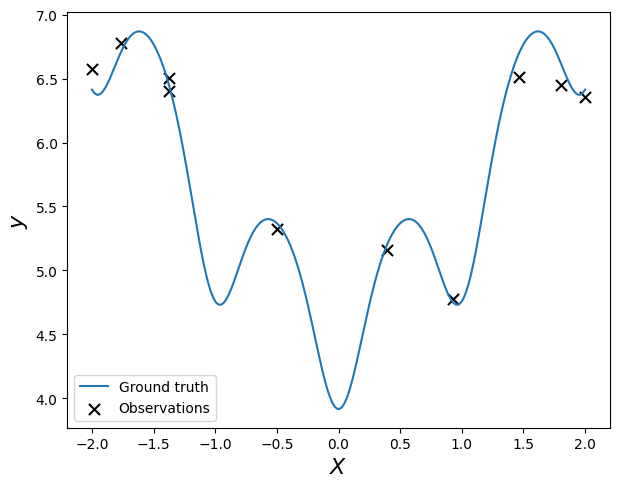

In [57]:
np.random.seed(42)

X_bounds = np.array([-2, 2])
X = np.random.uniform(X_bounds[0], X_bounds[1], size=(8,))
X = np.append(X, X_bounds)
X = np.sort(X)
y = measure(X)

X_unmeasured = np.linspace(X_bounds[0], X_bounds[1], 200)
ground_truth = measure(X_unmeasured, noise=0)


_, ax = plt.subplots(dpi=100, figsize=(7, 5.5))
ax.set_xlabel("$X$", fontsize=16)
ax.set_ylabel("$y$", fontsize=16)
ax.scatter(X, y, marker='x', c='k', s=64, zorder=1, label="Observations", alpha=1.0)
ax.plot(X_unmeasured, ground_truth, label='Ground truth')
ax.legend(loc='best');

The Gaussian process class in GPax uses a weakly informative $LogNormal(0,1)$ priors on all kernel parameters and model noise by default. If we have prior knowledge that the noise level is low, we may choose a more appropriate prior distibution for the noise, such as

In [ ]:
noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.01))

Next we define a single step that takes measured data, trains a GP model, and uses it to compute an Upper Confidence Bound (UCB) acquisition function for deriving the next measurment point (which will be done inside the main loop).

In [ ]:
def step(X_measured, y_measured, X_unmeasured):
    # Get random number generator keys for training and prediction
    rng_key1, rng_key2 = gpax.utils.get_keys()
    # Initialize GP model
    gp_model = gpax.ExactGP(1, kernel='RBF', noise_prior=noise_prior)
    # Run HMC to obtain posterior samples for the GP model parameters
    gp_model.fit(rng_key1, X_measured, y_measured)
    # Get predictions (we don't need this step for optimization - only for visualization purposes)
    y_pred, y_sampled = gp_model.predict(rng_key2, X_unmeasured, noiseless=True)
    # Compute acquisition function
    obj = gpax.acquisition.UCB(
        rng_key2, gp_model, X_unmeasured, beta=4,
        maximize=False, noiseless=True)
    return obj, (y_pred, y_sampled)

Finally, we run the Bayesian optimization for 7 steps to find the minimum of the unknown (to the algorithm) function:


Step 1/7


sample: 100%|██████████| 4000/4000 [00:07<00:00, 535.24it/s, 7 steps of size 4.11e-01. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.76      0.15      0.74      0.54      0.94    438.59      1.00
    k_scale     12.93      5.77     11.53      5.55     20.69   1066.66      1.00
      noise      0.01      0.01      0.01      0.00      0.02    744.41      1.00



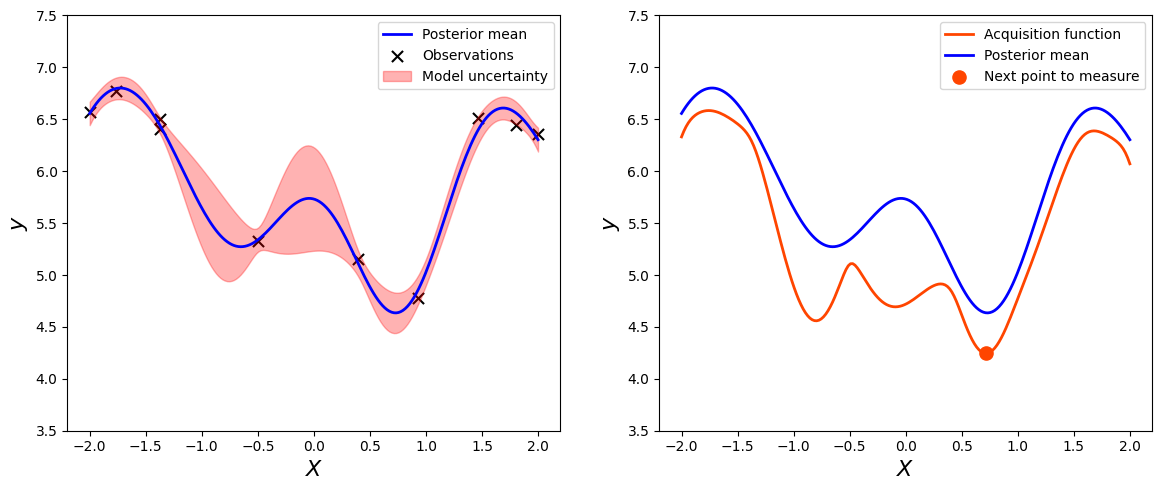


Step 2/7


sample: 100%|██████████| 4000/4000 [00:07<00:00, 555.44it/s, 3 steps of size 3.62e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.02      0.38      0.92      0.48      1.74    242.20      1.00
    k_scale     12.06      5.62     10.72      5.18     20.03    728.29      1.00
      noise      0.02      0.01      0.02      0.01      0.04    285.41      1.00



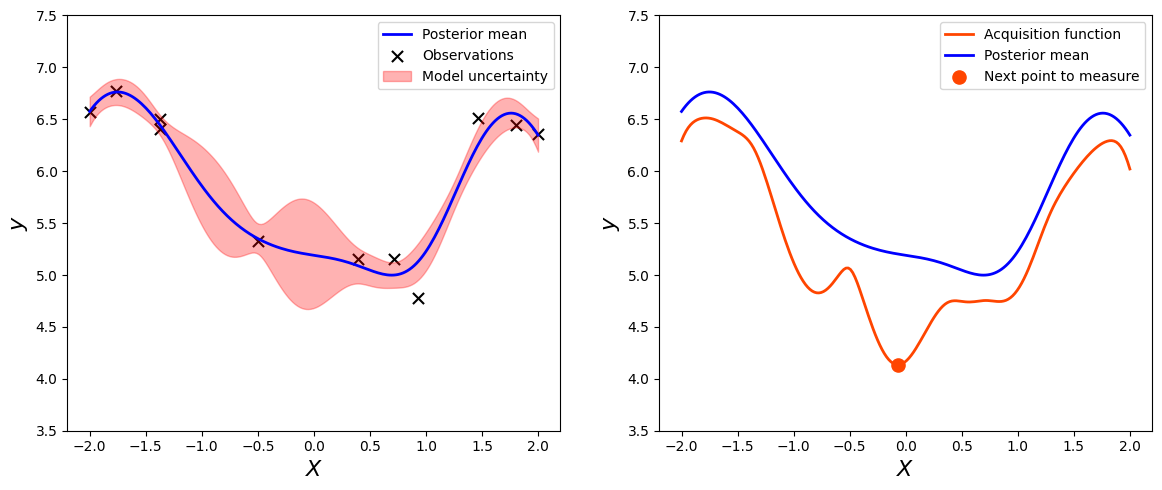


Step 3/7


sample: 100%|██████████| 4000/4000 [00:07<00:00, 540.85it/s, 7 steps of size 4.58e-01. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.53      0.06      0.53      0.44      0.63    860.57      1.00
    k_scale     14.25      5.87     12.97      6.02     22.10   1434.85      1.00
      noise      0.01      0.01      0.01      0.00      0.02   1538.37      1.00



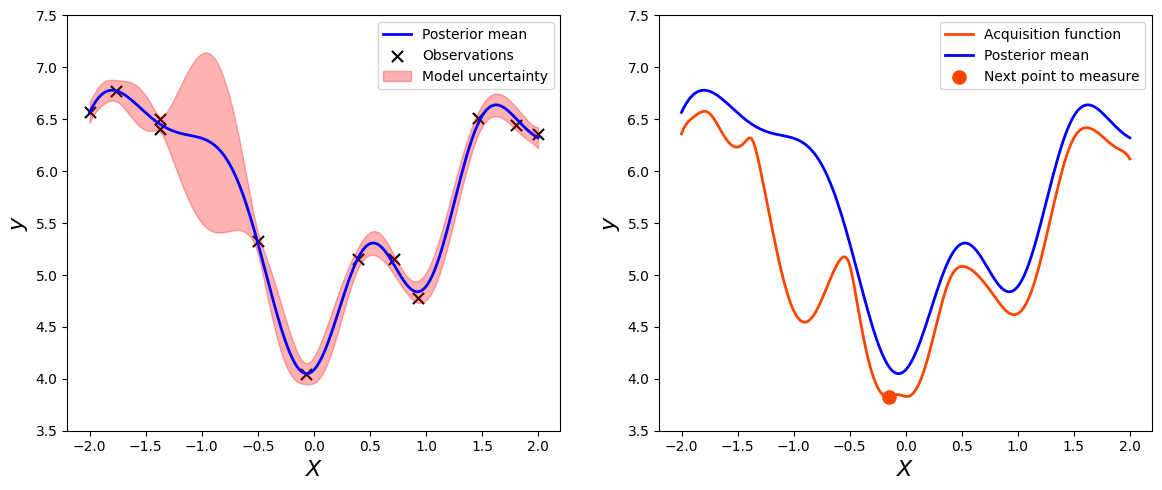


Step 4/7


sample: 100%|██████████| 4000/4000 [00:07<00:00, 555.30it/s, 7 steps of size 4.51e-01. acc. prob=0.96]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.53      0.06      0.53      0.44      0.62   1115.98      1.00
    k_scale     14.15      6.02     12.85      6.15     22.58   1090.75      1.00
      noise      0.01      0.01      0.01      0.00      0.02   1341.23      1.00



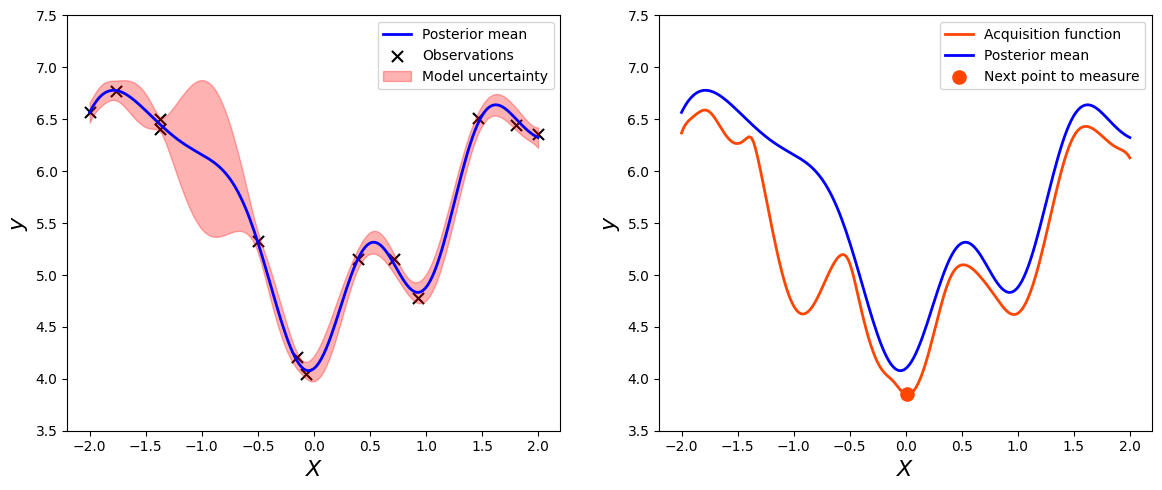


Step 5/7


sample: 100%|██████████| 4000/4000 [00:07<00:00, 512.81it/s, 7 steps of size 4.26e-01. acc. prob=0.97]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.49      0.05      0.49      0.40      0.57   1133.55      1.00
    k_scale     13.96      5.48     12.96      6.23     21.17   1074.03      1.00
      noise      0.01      0.01      0.01      0.00      0.02   1445.86      1.00



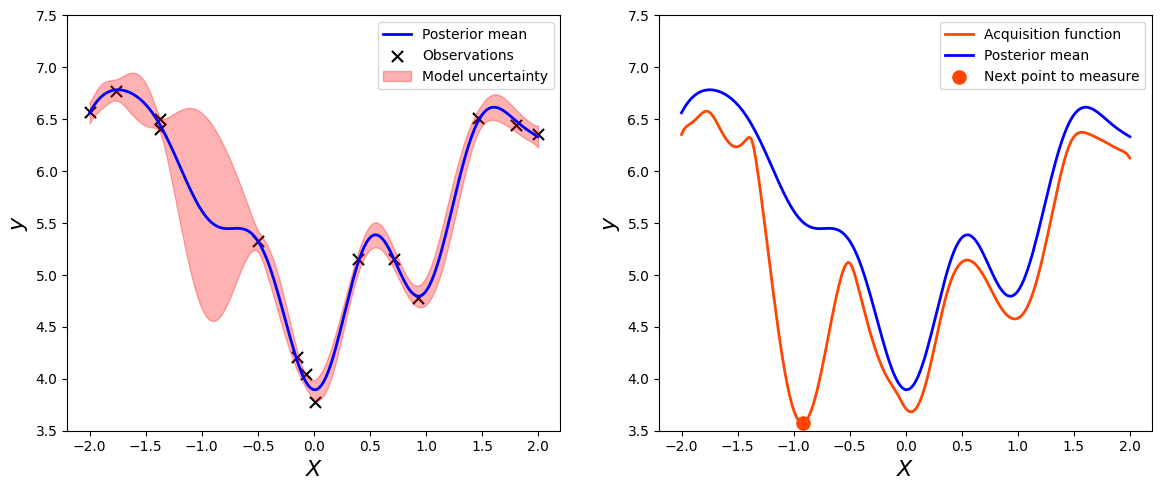


Step 6/7


sample: 100%|██████████| 4000/4000 [00:07<00:00, 556.52it/s, 7 steps of size 6.03e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.48      0.04      0.49      0.43      0.55   1482.71      1.00
    k_scale     14.45      5.89     13.23      6.44     22.12   1080.22      1.00
      noise      0.01      0.01      0.01      0.00      0.02   1618.85      1.00



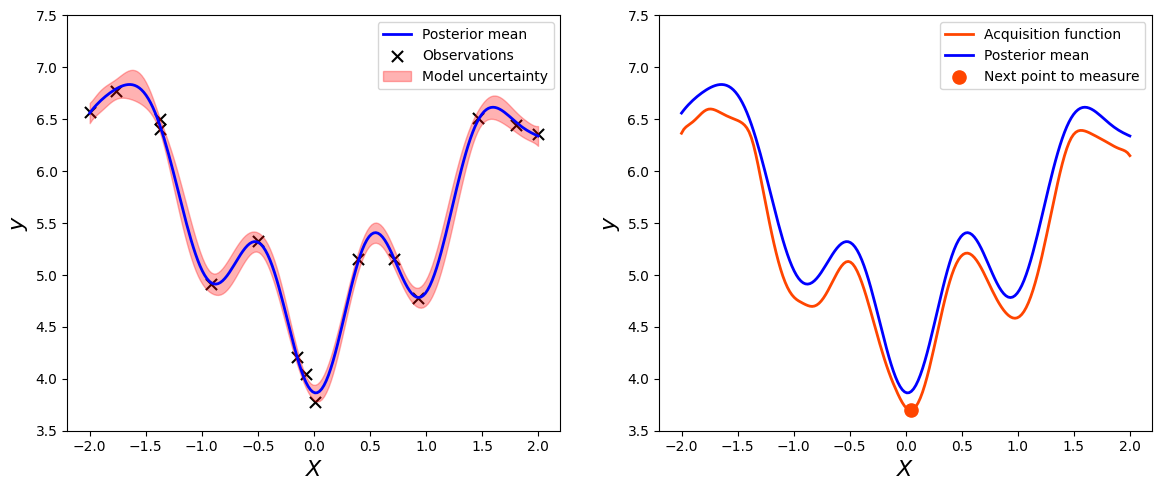


Step 7/7


sample: 100%|██████████| 4000/4000 [00:07<00:00, 559.89it/s, 15 steps of size 4.44e-01. acc. prob=0.97]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.49      0.04      0.49      0.43      0.55   1135.93      1.00
    k_scale     14.21      5.60     13.10      6.62     21.91   1172.47      1.00
      noise      0.01      0.00      0.01      0.00      0.02   1756.46      1.00



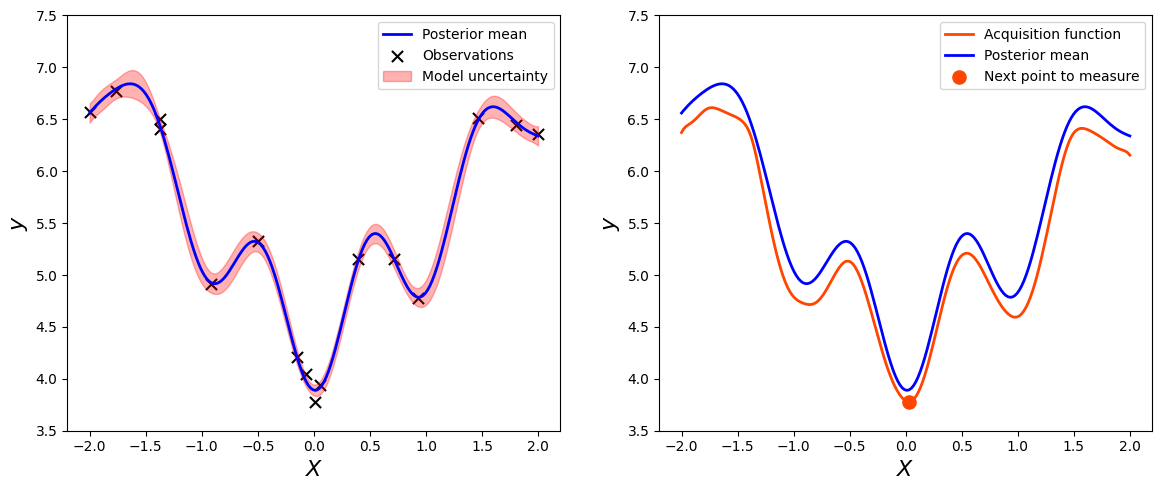

In [ ]:
num_steps = 7

for e in range(num_steps):
    print("\nStep {}/{}".format(e+1, num_steps))
    # Compute acquisition function
    acq, (y_pred, y_sampled) = step(X, y, X_unmeasured)
    # Get the next point to evaluate
    idx = acq.argmin()
    next_point = X_unmeasured[idx:idx+1]
    # Measure the point
    next_point_value = measure(next_point)
    # Update measured data
    X = np.append(X, X_unmeasured[idx:idx+1])
    y = np.append(y, next_point_value)

    # Plot observed points, mean prediction, and acqusition function
    lower_b = y_pred - y_sampled.std(axis=(0,1))
    upper_b = y_pred + y_sampled.std(axis=(0,1))
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(14, 5.5))
    ax1.scatter(X[:-1], y[:-1], marker='x', c='k', label="Observations", s=64)
    ax1.fill_between(X_unmeasured, lower_b, upper_b, color='r', alpha=0.3, label="Model uncertainty")
    ax2.plot(X_unmeasured, acq, lw=2, c='orangered', label='Acquisition function')
    ax2.scatter(X_unmeasured[idx], acq[idx], s=90, c='orangered', label='Next point to measure')
    for ax in fig.axes:
        ax.plot(X_unmeasured, y_pred, lw=2, c='b', label='Posterior mean')
        ax.set_ylim(3.5, 7.5)
        ax.set_xlabel("$X$", fontsize=16)
        ax.set_ylabel("$y$", fontsize=16)
        ax.legend(loc='best', fontsize=10)
    plt.show()

As one can see, the algorithm quickly converged onto the true minimum.